## Import the data

Use Pandas to import the data and prepare it for the models

In [ ]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.model_selection import cross_val_score



df = pd.read_csv('Dataset/dataset_phishing.csv')

#print null
print(df.isnull().sum())

#remove all null
df = df.dropna()

#describe statistical data. To stdout
with pd.option_context('display.max_columns', 40):
    print(df.describe(include='all'))

#describe statistical data to text file: out.txt
with open('out.txt', 'w') as f:
    with pd.option_context('display.max_columns', 40):
        print(df.describe(include='all'),file=f)
        
#shape of data
print('Number of rows are',df.shape[0], 'and number of columns are ',df.shape[1])

#look at data types of columns
print(df.info())

#Pair plot (takes way too long, we need to decide on important features first)
# plt.figure(figsize=(20,20))
# sns.pairplot(df)
# plt.savefig('./Figures/pairplot.png')
# plt.show()

#encode last column 
dummy_data = pd.get_dummies(df, columns = ['status'])


#Get X and y 
X = dummy_data.iloc[:,1:-1].values
y = dummy_data.iloc[:,-1].values

#try printing last column to make sure it's binary
print(y)
print(X)
print(X.shape, y.shape)

#Train, test, val split. 60%, 20%, 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#Doing test_train split for now, later cross validation
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print(f"X_train shape = {X_train.shape}, X_val shape = {X_val.shape}, X_test shape = {X_test.shape}")
print(f"y_train shape = {y_train.shape}, y_val shape = {y_val.shape}, y_test shape = {y_test.shape}")

## Random Forest Model

In [ ]:
#Feature scaling. Do we need this??
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
#just transform because we already did a fit above ^
X_test = scaler.transform(X_test)


#Random Forest
#default = 100
estimators = [10, 100, 500]
#default = None
max_leaf = [10, 50, None]

random_state = [0,20,40]
bestModel = 0
bestScore = 0
bestParams = [0,0,0]

#parellel arrays, so I can have the best, and also some worse models
scores = []
models = []


#will probably want to do some learning curves here 
for e in estimators:
    for m in max_leaf:
        for r in random_state:
            model = ensemble.RandomForestClassifier(n_estimators=e, max_leaf_nodes=m, random_state=r)
            model.fit(X_train,y_train.flatten())
            print(f"Training Score: {model.score(X_train,y_train)}")
            # it makes predictions using X_test under the hood and uses those predictions to calculate accuracy score
            score = model.score(X_val,y_val)
            models.append(model)
            scores.append(score)
            print(f"Validation Score: n_estimators = {e}, max_leaf = {m} , random = {r}, Score = {score}")
            if score > bestScore:
                bestModel = model
                bestScore = score
                bestParams = [e,m,r]
                
            

print(f"Best Model: n_estimators = {bestParams[0]}, max_leaf = {bestParams[1]} , random = {bestParams[2]}, Score = {bestScore}")

#check test score of best model
print(f"Best Model Test Score: {bestModel.score(X_test, y_test)}")

scores = np.array(scores)
models = np.array(models, dtype=object)

#sorts in ascending order
bestIndices = np.argsort(scores)
ascendingModels = []
for i in bestIndices:
    ascendingModels.append(models[i])
    
print(ascendingModels[-1])
bestModel2 = ascendingModels[-1]
print(ascendingModels[0])
worstModel = ascendingModels[0]

    



## Learning Curves for Random Forest

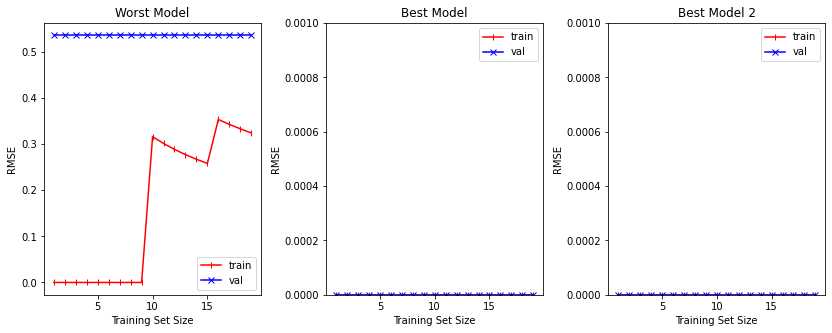

In [10]:
# #Learning curve for best model (and maybe try another model or 2?)
from sklearn.metrics import mean_squared_error

# reccomended - a function to compute data and draw the learning curves
def plot_learning_curves(model, Xtrain, ytrain, Xval, yval, ax):
    
    mTrain = Xtrain.shape[0]
    
    #will be used to graph later
    Jtrain = []
    Jval = []
    
    trainingExamples = 20
    
    #loop up to mTrain, taking small subsets of the train data set from 1-mTrain
    for m in range(1,trainingExamples):
        #create subset of training data
        XTrainTemp = Xtrain[0:m,:]
        yTrainTemp = ytrain[0:m]

        model.fit(Xtrain, ytrain.flatten())
        yTrainPred = model.predict(XTrainTemp)
        #test validation on the whole data set
        yValPred = model.predict(Xval)
#         print(yTrainTemp.shape)
#         print(yTrainPred.shape)
        
        #squared = False -> RMSE rather than MSE
        Jtrain.append(mean_squared_error(yTrainTemp,yTrainPred, squared=False ))
        #also need to test validation on the whole set
        Jval.append(mean_squared_error(yval,yValPred, squared=False ))
    #plot
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('RMSE')
    i = [int(x) for x in range(1,trainingExamples)]
    ax.plot(i,Jtrain,"r-|",label="train")
    ax.plot(i,Jval,"bx-",label="val")
    ax.legend(loc = 'best')
    
fig = plt.figure(figsize=(14, 5))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(131)
ax1.set_title("Worst Model")
ax2 = fig.add_subplot(132)
ax2.set_title("Best Model")
ax3 = fig.add_subplot(133)
ax3.set_title("Best Model 2")
ax2.set_ylim(0,0.001);
ax3.set_ylim(0,0.001);

# ax3.set_ylim(0,200);
    
#Learning Curvues for Random Forest 

#worst model, a litle underfitting
plot_learning_curves(worstModel, X_train, y_train, X_val, y_val, ax1)
#next 2 are both 100%
plot_learning_curves(bestModel, X_train, y_train, X_val, y_val, ax2)
plot_learning_curves(bestModel2, X_train, y_train, X_val, y_val, ax3)
    


## Feature Importance for Random Forest

In [ ]:
#probabilities that determine each feature's importance
featureImportance = bestModel.feature_importances_
# print(featureImportance)
# print(featureImportance.shape)

#in ascneding order
sortedIndices = np.argsort(featureImportance)
descendingIndices = np.flip(sortedIndices,0)

#a list that goes from best -> worst features
bestFeatures = []
for i in descendingIndices:
    bestFeatures.append(df.columns[i])
    
print("Here are the 10 best features")
for i in range(10):
    print(bestFeatures[i])
    



In [ ]:
## Data Visualization With Best Features

In [ ]:
# plt.figure(figsize=(20,20))
# sns.pairplot(df, vars = bestFeatures)
# plt.savefig('./Figures/pairplot.png')
# plt.show()

## Clustering

In [9]:
from sklearn.cluster import KMeans
km1 = KMeans(n_clusters=2, random_state=0).fit(X_train)
#This doesn't really make sense. Hmmm
print(km1.score(X_train, y_train))

-526853.9683796194


## Cross Validation on Random Forest Model

In [ ]:
for e in estimators[:-2]:
    for m in max_leaf[:-2]:
        for r in random_state[:-2]:
            model = ensemble.RandomForestClassifier(n_estimators=e, max_leaf_nodes=m, random_state=r)
            model.fit(X_train,y_train.flatten())
            # it makes predictions using X_test under the hood and uses those predictions to calculate accuracy score
            score = cross_val_score(model, X, y.flatten(), cv=5)
            print(f"model - estimators = {e}; max_leaf = {m}; random_state = {r}:{score}")